In [1]:

import time
import os
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
from numpy import array
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
import pickle


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_class_weight

#Model Performance Evaluators
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import log_loss



from joblib import parallel_backend
from joblib import Parallel, delayed

import dask
from dask.distributed import Client, progress, LocalCluster, SSHCluster,wait
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from PyALE import ale
from dask import delayed


In [2]:
#import data

comb_dinuc_df= pd.read_csv('/cluster/pixstor/slotkinr-lab/sandaruwan/rubyRF/WT_dcr_red/trainRF/data_sets/WT_wtdcr_train_set1_di_df.txt',header=0,sep='\t')


np.shape(comb_dinuc_df)

#shuffle and reset index
shuf_comb_dinuc_df=comb_dinuc_df.iloc[np.random.permutation(len(comb_dinuc_df))]

shuf_comb_dinuc_df=shuf_comb_dinuc_df.reset_index(drop=True)




In [3]:
#drop seq_id
shuf_comb_dinuc_dfdrp= shuf_comb_dinuc_df.drop(['seq_id'],axis=1)
shuf_comb_dinuc_dfdrp.head()

,5p,3p,strand,ptype,length,gc_cont,AA,AC,AG,AT,...,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
0,710,1297,1,0,591,0.576988,29,34,42,24,...,37,43,33,54,26,27,10,49,35,27
1,4570,4841,1,1,299,0.357860,64,7,14,23,...,10,15,22,12,10,20,14,15,29,25
2,710,852,1,0,145,0.572414,5,6,9,10,...,9,13,10,13,6,3,2,16,8,6
3,3880,4021,1,0,142,0.591549,5,9,8,7,...,10,13,7,13,8,4,2,16,6,5
4,4690,4805,1,0,132,0.265152,31,0,3,11,...,2,5,6,4,4,13,7,4,18,22


In [4]:
ydt=shuf_comb_dinuc_df['ptype']

xdt=shuf_comb_dinuc_df.drop(['seq_id','ptype'],axis=1)



In [5]:
Xdt_sc = StandardScaler().fit_transform(xdt)


pcat = PCA(n_components=2)

Xdt_PC = pcat.fit_transform(Xdt_sc)


In [6]:
pca_df=pd.DataFrame(data=Xdt_PC,columns=['PC1','PC2'])
pca_df.head()

,PC1,PC2
0,-1.712054,0.831886
1,0.612033,-1.522641
2,-3.051817,1.025508
3,-1.582736,1.390563
4,1.414780,1.223982


In [7]:
final_pca_df=pd.concat([pca_df,shuf_comb_dinuc_df[['ptype']]],axis=1)
final_pca_df.head()

,PC1,PC2,ptype
0,-1.712054,0.831886,1
1,0.612033,-1.522641,1
2,-3.051817,1.025508,1
3,-1.582736,1.390563,0
4,1.414780,1.223982,0


In [9]:
# plt.rcParams.update({'font.size': 50})
# fig = plt.figure(figsize = (40,40))
# ax = fig.add_subplot(1,1,1) 
# ax.set_xlabel('PC 1')
# ax.set_ylabel('PC 2')
# ax.set_title('PCA')
# legend_labels = ['Red', 'Green']
# pts = [0, 1]
# colors = ['#D80673', '#06D826']
# for ptype, color in zip(pts,colors):
#     indicesToKeep = final_pca_df['ptype']==ptype
#     ax.scatter(final_pca_df.loc[indicesToKeep, 'PC1']
#                , final_pca_df.loc[indicesToKeep, 'PC2']
#                , c = color
#                , s = 100,alpha=0.4)
# ax.legend(pts,labels = legend_labels)
# ax.grid()

In [5]:
######################### split data #####################################

#split test train data
Xdt_train, Xdt_test, ydt_train, ydt_test = train_test_split(xdt, ydt, test_size=0.2, random_state=256)

#only if cross-validation is not used
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Xdt_train.shape, Xdt_test.shape


((2372436, 21), (593110, 21))

In [6]:
with parallel_backend('threading',n_jobs=32 ):


    
    # Calculate class weights
    #class_weights = compute_class_weight('balanced', classes=np.unique(ydt_train), y=ydt_train)
    #class_weights

    rfc_dicomb = RandomForestClassifier(random_state=3500,n_estimators = 250,n_jobs=32)
    #class_weight=dict(enumerate(class_weights) ))


#parameter tuned model

#    rfc_dicomb = RandomForestClassifier(random_state=3500,n_estimators = 400,n_jobs=32,
#     class_weight=dict(enumerate(class_weights) ),
#     criterion='log_loss',
#        max_depth=100,
#        min_samples_split=10,
#        min_samples_leaf=2,
#        max_features='log2',
#        bootstrap=True
#        )


    print('training >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
    #model train
    rfc_dicomb.fit(Xdt_train, ydt_train)


    # Predict the Test set results

    y_pred =  rfc_dicomb.predict(Xdt_test)

training >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


In [7]:
###############################################################################

# test accuracy score 

from sklearn.metrics import accuracy_score

print('Model test accuracy : {0:0.4f}'. format(accuracy_score(ydt_test, y_pred)))



print ("\nClassification report :\n",(classification_report(ydt_test,y_pred)))



Model test accuracy : 0.8454

Classification report :
               precision    recall  f1-score   support

           0       0.86      0.85      0.85    314135
           1       0.83      0.84      0.84    278975

    accuracy                           0.85    593110
   macro avg       0.84      0.85      0.84    593110
weighted avg       0.85      0.85      0.85    593110



In [14]:
mfilename='/shares/kslotkin_share/private/tratnayake/frNAnet/models/rfc_WTvdcr_comb_set1_v1.pkl'

pickle.dump( rfc_dicomb,open(mfilename,'wb'))

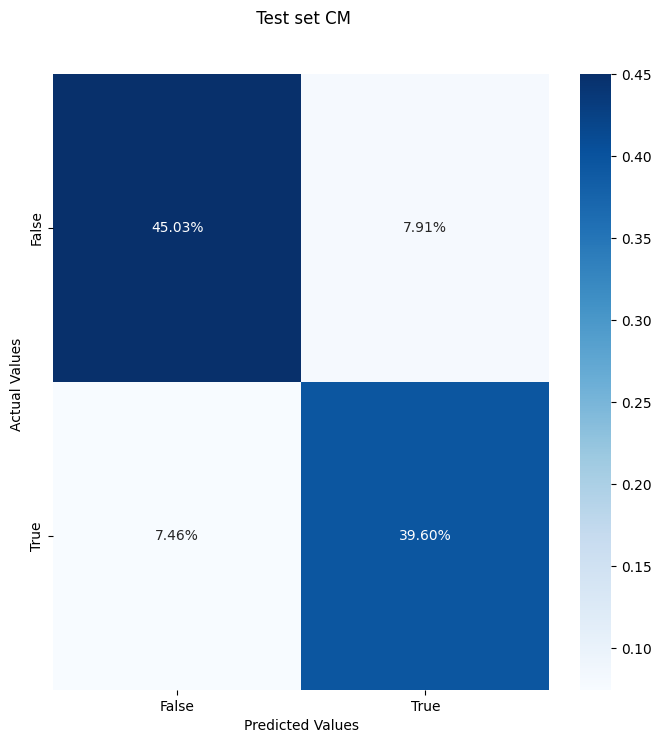

In [15]:
plt.rcParams.update({'font.size': 10})

# #####################################  CONFUSION MATRIX for test set   ########################################################################
fig1=plt.figure(figsize = (8,8))
cm = confusion_matrix(y_true=ydt_test, y_pred=y_pred)

ax = sns.heatmap(cm/np.sum(cm), annot=True,
            fmt='.2%', cmap='Blues')

ax.set_title(' Test set CM\n\n');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


fig1 = ax.get_figure()
#figure.savefig('svm_conf.png', dpi=400)

#fig=plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
#fig1.savefig("RFC_URSR_comb_S220316070514_v2.png")

In [8]:
client = Client(processes=False, threads_per_worker=1, n_workers=32, memory_limit='120GB')


In [9]:
start_time=time.time()


# Scatter X data to workers
Xdt_test_dask = client.scatter(Xdt_test, broadcast=True)
# Scatter y data to workers
ydt_test_dask = client.scatter(ydt_test, broadcast=True)  


@dask.delayed
def compute_permutation_importance(model, X, y, n_repeats=10, random_state=42):
    
    result = permutation_importance(model, X, y, n_repeats=n_repeats, random_state=random_state)
    return result

# Compute permutation importance with Dask delayed computation
perm_importance_delayed = compute_permutation_importance(rfc_dicomb, Xdt_test_dask, ydt_test_dask)

# Compute the result
perm_importance_t3 = perm_importance_delayed.compute()


end_time=time.time()
total_time=end_time-start_time
print("execution time",total_time,"s")


/mnt/pixstor/data/tsrbcx/miniconda/envs/sickt_ml/lib/python3.10/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 11.68 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


execution time 770.9050400257111 s


In [10]:
client.close()

In [11]:
sorted_idx = perm_importance_t3.importances_mean.argsort()
top_fidx=sorted_idx[-22:]

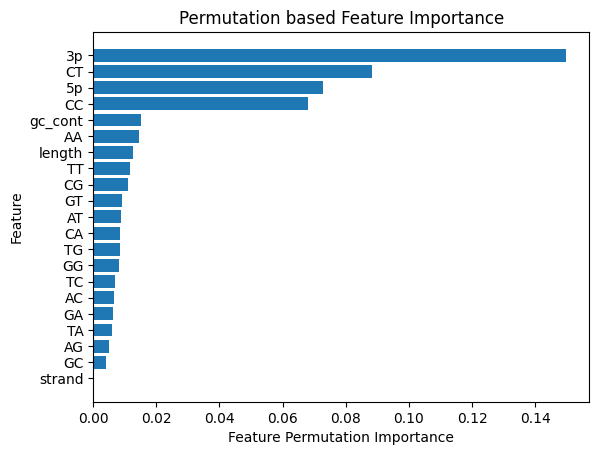

In [12]:
plt.rcParams.update({'font.size': 10})
fig4=plt.figure()
plt.barh(Xdt_train.columns[top_fidx], perm_importance_t3.importances_mean[top_fidx])
plt.xlabel("Feature Permutation Importance")
plt.ylabel('Feature')
plt.title('Permutation based Feature Importance')
fig4.savefig("Permutation_based_FI_dinuc_dcrwt_SRWT_pct.pdf")
